In [1]:
# You may want to install "gprof2dot" 
import io
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import random
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin

import pydot

In [2]:
eps = 1e-5  # a small number     

# Question 4: Decision Trees for Classification

## 4.1: Implement Decision Trees

In [3]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        # adding max number of features m
        self.m = m
        

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO: implement information gain function
        # H(S) - H(after)
    
        splitl = np.where(X <= thresh)
        splitr = np.where(X > thresh)
    
        # Splitting the labels based on the threshold 
        sl = y[splitl]
        sr = y[splitr]
        
        HS = DecisionTree.entropy(y)
        HSL = DecisionTree.entropy(sl)
        HSR = DecisionTree.entropy(sr)
        
        H_after = ((len(sl) * HSL) + (len(sr) * HSR)) / (len(sl) + len(sr))
        
        return (HS - H_after)

    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO: implement gini impurity function
        pass
    
    @staticmethod
    def entropy(y):
        # TODO: implement entropy function
        H = 0
        sorted_y, unique_counts = np.unique(y, return_counts = True)
        num_classes = len(sorted_y)
        for i in unique_counts:
            pc = i / num_classes
            product = pc * np.log2(pc)
            H += product
        return H

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            
            # picking m random features out of total d features and selecting only those features for X
            data = X
            if self.m:
                m_feature_ids = np.random.choice(X.shape[1], size = self.m, replace = False)
                X = data[:, m_feature_ids]
            else:
                X = data

            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            
            if self.m:
                for i in range(self.m):
                    gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])
            else:
                for i in range(X.shape[1]):
                    gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            if self.m:
                self.split_idx = m_feature_ids[self.split_idx]
            
            # splitting on the original data
            X0, y0, X1, y1 = self.split(data, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())



## 4.2 Implement Random Forest

In [4]:
class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, m_depth = 3, n = 200, features = None):
        self.n = n
        self.m_depth = m_depth
        self.decision_trees = [
            DecisionTree(max_depth = m_depth, feature_labels = features) for i in range(self.n)]

    def fit(self, X, y):
        # TODO: implement function
        for n in range(self.n):
            row = X.shape[0]
            sample = np.random.choice(np.arange(row), size = row, replace = True)
            X_train = X[sample]
            y_train = y[sample]
            self.decision_trees[n].fit(X_train, y_train)
        return self

    def predict(self, X):
        # TODO: implement function   
        y_hats = []
        for i in range(self.n):
            pred = self.decision_trees[i].predict(X)
            y_hats.append(pred)

        return np.round(np.mean(y_hats, axis=0))

In [5]:
class RandomForest(BaggedTrees):
    def __init__(self, m_depth, features, n=200, m=1): 
        # TODO: implement function
        self.params = params
        self.m = m
        self.n = n
        self.decision_trees = [
            DecisionTree(max_depth = m_depth, feature_labels = features, m = m) for i in range(self.n)]
        
        

In [6]:
class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO: implement function
        return self

    def predict(self, X):
        # TODO: implement function
        pass


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)

## 4.3 Describe Implementation Details

1.) The process to clean the data consisted of removing rows where labels (whether they survived or not) were completely missing. This ensured that every row would have a corresponding label. In addition, hotcoding allowed categorical variables such as gender or embarked to be mapped to binary vectors of zeros and ones. This helped deal with the catagorical features. In addition, to account for missing data values, we could use the mode of each feature and input that into each missing data value.

2.) I used the maximum depth as my stopping criterion. A depth that is too high can result in overfitting, so I had to make sure to use a depth that would not increase the bias too much. 

3.) I added a m value to my decision tree class to choose m features before splitting between features. Additionally, since my Random Forest inherited my BaggedTrees class, I simply created a list of decision trees (a forest if you will) using m features. For my BaggedTrees class, I sampled with replacement and trained on each sample. I had my forest pick the the optimal sample from my BaggedTrees class. 

4.) I did not do anything special to optimize speed. 

5.) No

In [7]:
if __name__ == "__main__":
    dataset = "titanic"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data
        path_train = './dataset/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
        path_test = './dataset/titanic/titanic_test_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
        y = data[1:, -1]  # label = survived
        class_names = ["Died", "Survived"]
        labeled_idx = np.where(y != '')[0]

        y = np.array(y[labeled_idx])
        y = y.astype(float).astype(int)


        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, :-1]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = './dataset/spam/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features:", features)
    print("Train/test size:", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # Basic decision tree
    print("\n\nPart (a-b): simplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)
    print("Predictions", dt.predict(Z)[:100])
    
    

    print("\n\nPart (c): sklearn's decision tree")
    clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X, y)
    evaluate(clf)
    out = io.StringIO()

    # You may want to install "gprof2dot"
    sklearn.tree.export_graphviz(
        clf, out_file=out, feature_names=features, class_names=class_names)
    graph = pydot.graph_from_dot_data(out.getvalue())
    pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

    # TODO: implement and evaluate!




Part (b): preprocessing the titanic dataset
Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'male', 'female', 'S', 'C', 'Q']
Train/test size: (999, 14) (310, 14)


Part 0: constant classifier
Accuracy 0.6166166166166166


Part (a-b): simplified decision tree
Predictions [0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]


Part (c): sklearn's decision tree
Cross validation [0.795      0.825      0.805      0.755      0.74371859]


## 4.4 Performance Evaluation

In [8]:
def shuffle_data(array1, array2, num):
    merged_list = list(zip(array1, array2))
    
    shuffled = random.sample(merged_list, len(merged_list))
    
    unfiltered_training, unfiltered_val = shuffled[num:], shuffled[:num]
    
    X_training_data, y_training_labels = zip(*unfiltered_training)
    X_validation_data, y_validation_labels = zip(*unfiltered_val)
    
    return np.asarray(X_training_data), np.asarray(y_training_labels), np.asarray(X_validation_data), np.asarray(y_validation_labels)

In [9]:
spamData = scipy.io.loadmat("dataset/spam/spam_data.mat")
spam_trainingData = spamData['training_data']
spam_trainingLabels = spamData['training_labels']
spam_test = spamData['test_data']

spam_training_data, spam_training_labels, spam_val_data, spam_val_labels = shuffle_data(
    spam_trainingData, spam_trainingLabels, int(spam_trainingData.shape[0] * 0.2))

feat = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]

In [10]:
decisionTree = DecisionTree(max_depth = 6)
randomForest = RandomForest(m_depth = 5, features = feat, n=200, m=4)

decisionTree.fit(spam_training_data, spam_training_labels)
randomForest.fit(spam_training_data, spam_training_labels)

spam_training_pred = decisionTree.predict(spam_training_data)
spam_val_pred = decisionTree.predict(spam_val_data)
spam_training_pred_forest = randomForest.predict(spam_training_data)
spam_val_pred_forest = randomForest.predict(spam_val_data)

# Training accuracies 
spam_training_acc = np.sum(spam_training_pred == spam_training_labels.flatten()) / spam_training_data.shape[0]
spam_training_acc_forest = np.sum(spam_training_pred_forest == spam_training_labels.flatten()) / spam_training_data.shape[0]

# Validation accuracies 
spam_val_acc = np.sum(spam_val_pred == spam_val_labels.flatten()) / spam_val_data.shape[0]
spam_val_acc_forest = np.sum(spam_val_pred_forest == spam_val_labels.flatten()) / spam_val_data.shape[0]

print(f"Training accuracy for SPAM using a Decision Tree: {spam_training_acc}.")
print(f"Validation accuracy for SPAM using a Decision Tree: {spam_val_acc}.")

print(f"Training accuracy for SPAM using a Random Forest: {spam_training_acc_forest}.")
print(f"Validation accuracy for SPAM using a Random Forest: {spam_val_acc_forest}.")


Training accuracy for SPAM using a Decision Tree: 0.790719696969697.
Validation accuracy for SPAM using a Decision Tree: 0.7935606060606061.
Training accuracy for SPAM using a Random Forest: 0.7831439393939394.
Validation accuracy for SPAM using a Random Forest: 0.7945075757575758.


In [11]:
# Load and preprocess the titanic data
path_train = './dataset/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
path_test = './dataset/titanic/titanic_test_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
y = data[1:, -1]  # label = survived
class_names = ["Died", "Survived"]
labeled_idx = np.where(y != '')[0]

y = np.array(y[labeled_idx])
y = y.astype(float).astype(int)

X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
features = list(data[0, :-1]) + onehot_features

titanicData = X
titanicLabels = y
titanicFeatures = features
titanicTest = Z

titanic_training_data, titanic_training_labels, titanic_val_data, titanic_val_labels = shuffle_data(
    titanicData, titanicLabels, int(titanicData.shape[0] * 0.2))

In [22]:
decisionTree = DecisionTree(max_depth = 5)
randomForest = RandomForest(m_depth = 6, features = titanicFeatures, n=200, m=4)

decisionTree.fit(titanic_training_data, titanic_training_labels)
randomForest.fit(titanic_training_data, titanic_training_labels)

titanic_training_pred = decisionTree.predict(titanic_training_data)
titanic_val_pred = decisionTree.predict(titanic_val_data)
titanic_training_pred_forest = randomForest.predict(titanic_training_data)
titanic_val_pred_forest = randomForest.predict(titanic_val_data)

# Training accuracies 
titanic_training_acc = np.sum(titanic_training_pred == titanic_training_labels.flatten()) / titanic_training_data.shape[0]
titanic_training_acc_forest = np.sum(titanic_training_pred_forest == titanic_training_labels.flatten()) / titanic_training_data.shape[0]

# Validation accuracies 
titanic_val_acc = np.sum(titanic_val_pred == titanic_val_labels.flatten()) / titanic_val_data.shape[0]
titanic_val_acc_forest = np.sum(titanic_val_pred_forest == titanic_val_labels.flatten()) / titanic_val_data.shape[0]

print(f"Training accuracy for Titanic using a Decision Tree: {titanic_training_acc}.")
print(f"Validation accuracy for Titanic using a Decision Tree: {titanic_val_acc}.")

print(f"Training accuracy for Titanic using a Random Forest: {titanic_training_acc_forest}.")
print(f"Validation accuracy for Titanic using a Random Forest: {titanic_val_acc_forest}.")


Training accuracy for Titanic using a Decision Tree: 0.65625.
Validation accuracy for Titanic using a Decision Tree: 0.5778894472361809.
Training accuracy for Titanic using a Random Forest: 0.78375.
Validation accuracy for Titanic using a Random Forest: 0.7487437185929648.


In [13]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv("titanicPrediction2.csv", index_label='Id')

In [14]:
spam_model_forest = DecisionTree(max_depth = 17)
spam_model_forest.fit(spamData["training_data"], spamData["training_labels"])
spamPredictions = spam_model_forest.predict(spamData["test_data"])
results_to_csv(spamPredictions)

In [15]:
titanicModel = RandomForest(m_depth = 6, features = titanicFeatures, n=300, m=4)
titanicModel.fit(titanicData, titanicLabels)
titanicPredictions = titanicModel.predict(titanicTest)
results_to_csv(titanicPredictions)

Kaggle Username: nadaleek

SPAM Score: 0.80394

Titanic Score: 0.73548

## 4.5 Writeup the Spam Dataset

drug > 1e-5

exclamation > 1e-5

semicolon < 1e-5

perscription < 1e-5

spam > 1e-5

money > 1e-5

Therefore, the prediction is spam

business > 1e-5

message > 1e-5

pain < 1e-5

ampersand < 1e-5

other < 1e-5

Therefore, this prediction is ham

In [17]:
spam_training_data, spam_training_labels, spam_val_data, spam_val_labels = shuffle_data(
    spam_trainingData, spam_trainingLabels, int(spam_trainingData.shape[0] * 0.2))

depths = np.arange(1, 41)
val_acc = []
for depth in depths:
    decisionTree = DecisionTree(max_depth = depth)
    decisionTree.fit(spam_training_data, spam_training_labels)
    prediction = decisionTree.predict(spam_val_data)
    spam_val_acc = np.sum(prediction == spam_val_labels.flatten()) / spam_val_data.shape[0]
    val_acc.append(spam_val_acc)
    print(f"Depth {depth} done")

Depth 1 done
Depth 2 done
Depth 3 done
Depth 4 done
Depth 5 done
Depth 6 done
Depth 7 done
Depth 8 done
Depth 9 done
Depth 10 done
Depth 11 done
Depth 12 done
Depth 13 done
Depth 14 done
Depth 15 done
Depth 16 done
Depth 17 done
Depth 18 done
Depth 19 done
Depth 20 done
Depth 21 done
Depth 22 done
Depth 23 done
Depth 24 done
Depth 25 done
Depth 26 done
Depth 27 done
Depth 28 done
Depth 29 done
Depth 30 done
Depth 31 done
Depth 32 done
Depth 33 done
Depth 34 done
Depth 35 done
Depth 36 done
Depth 37 done
Depth 38 done
Depth 39 done
Depth 40 done


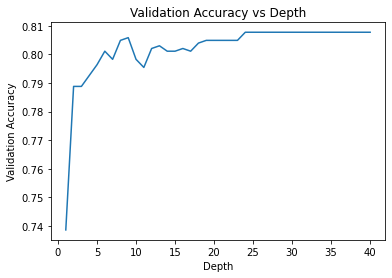

The optimal depth is 23


In [18]:
plt.plot(depths, val_acc, label="Validation Data")
plt.xlabel("Depth")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Depth")
plt.show()

max_val = max(val_acc)
max_depth = val_acc.index(max_val)
print(f"The optimal depth is {max_depth}")

## 4.6 Writeup for the Titanic Dataset

In [19]:
titanicModel = DecisionTree(max_depth = 3)
mod = titanicModel.fit(titanicData, titanicLabels)

In [20]:
fig = plt.figure(figsize=(25,20))
_ = sklearn.tree.plot_tree(titanicModel, feature_names = titanicFeatures)
plt.show()

NotFittedError: This DecisionTree instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 1800x1440 with 0 Axes>